In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import gym
import time
import zmq
from IPython.display import clear_output, display
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats

In [2]:
# Make ZMQ connection

#  Socket to talk to server
# print("Connecting server…")
# socket = context.socket(zmq.REQ)
# socket.connect("tcp://localhost:5555")

# socket.send(b"res")

# # get the state
# state = socket.recv()
# # clean it and convert to np array
# state = cleanmsg(state)


In [3]:
# Hyper Parameters
BATCH_SIZE = 128
LR = 0.001                   # learning rate
EPSILON = 0.9               # greedy policy
GAMMA = 0.9                 # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
MEMORY_CAPACITY = 1001
N_ACTIONS = 5

# define funciton to clean the message received from java
def cleanmsg(state):
    state = str(state)
    state = state.replace("null","0")
    state = state.replace("b'","").replace("'","").split(',')
    state = np.asarray(state, dtype=np.float32)
    return state
N_STATES = 1

In [4]:
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(N_STATES, 30)
        self.fc1.weight.data.normal_(0, 0.1)   # initialization
        self.fc2 = nn.Linear(30, 30)
        self.fc2.weight.data.normal_(0, 0.1)   # initialization
        self.out = nn.Linear(30, N_ACTIONS)
        self.out.weight.data.normal_(0, 0.1)   # initialization

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        actions_value = self.out(x)
        return actions_value

In [5]:
class DQN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter = 0                                     # for target updating
        self.memory_counter = 0                                         # for storing memory
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))     # initialize memory
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)

    
    def choose_action(self, x):
        x = Variable(torch.unsqueeze(torch.FloatTensor(x), 0))
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()[0]     # return the argmax
            #print("action:",action)
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            #print("random action")
        return action

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, [a, r], s_))
        # replace the old memory with new memory
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        for i in range(500):
            # sample batch transitions
            sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
            b_memory = self.memory[sample_index, :]
            b_s = Variable(torch.FloatTensor(b_memory[:, :N_STATES]))
            b_a = Variable(torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int)))
            b_r = Variable(torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2]))
            b_s_ = Variable(torch.FloatTensor(b_memory[:, -N_STATES:]))
            

            # q_eval w.r.t the action in experience
            q_eval = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
            q_next = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
            q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)   # shape (batch, 1)
            #print("q_eval:",q_eval.size())
            #print("q_target:",q_target.size())
            #loss = self.loss_func(q_eval, q_target)
            #print("target",q_target.shape,q_target.size)
            #print("target",q_target)
            loss = F.mse_loss(q_eval, q_target)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()


In [6]:
dqn = DQN()

In [7]:
context = zmq.Context()

#  Socket to talk to server
print("Connecting server…")
socket = context.socket(zmq.REQ)
socket.connect("tcp://localhost:5555")

print('\nCollecting experience...')
states = np.array([])
speed_avg = np.array([])
#dis_avg = np.array([])
#dis = np.array([])
rewards = np.array([])

for i_episode in range(400):
    # reset the environe
    socket.send(b"res")
    s = socket.recv()
    s = cleanmsg(s)
    #states = np.append(states, s)
    ep_r = 0
    done = False
    print("Episode:",i_episode)
    start = time.time()
    states = np.array([])
    
    for j in range(3000):
        a = dqn.choose_action(s)    
        if a == 0:
            socket.send(b"inclit")
        elif a==1:
            socket.send(b"inclot")
        elif a==2:
            socket.send(b"declit")
        elif a==3:
            socket.send(b"declot")
        elif a==4:
            socket.send(b"nth")
       
        '''
        #only for steering version
        if a == 0:
            socket.send(b"right")
        elif a==1:
            socket.send(b"left")
        elif a==2:
            socket.send(b"straight")
        '''
        
        s_ = socket.recv()
        s_ = cleanmsg(s_)
        #print("distances: " ,  s_)
        #dis = np.append(dis , s_[0])
        
        states = np.append(states, s_[0])
        if (abs(5-s_[0]) < 0.5):
            #print("Diff: " , abs(5-s_[0]) )
            r = (1 - abs(5-s_[0]))*(100)
        else:
            r = abs(5-s_[0])*(-10)
       
        if(s_[0]<0.5):
            r = r - 100
        
        if (s_[0]>15) or j>100:
            print("Restart:",s)
            done = True

        '''
        #Steering Version
        states = np.append(states, s)
        if (s_[0] < 0.5):
            r = (1- s_[0]) * 1000
        else:
            r = s_[0] * (-100) 
        
        if (s_[0]>1.5) or j>3000:
            if(s_[0]>1.5):
                r = r - 100
            print("Restart:", s)
            done = True
        '''
        
        '''
        #Steering Version
        if (s_[2] > 0):
            print("left is positive: " , s_[2])
        if (s_[1] < 0 ): 
            print("right is negativ: ", s_[1] )
        '''
        
        dqn.store_transition(s, a, r, s_)
        ep_r += r
        
        if (dqn.memory_counter % 100)==0:
            print("Memory counter:",dqn.memory_counter)
        
        if dqn.memory_counter > MEMORY_CAPACITY:
            dqn.learn()
            if done:
                ep_r += 10 * j
                print('Ep: ', i_episode,
                      '| Ep_r: ', round(ep_r, 2))
                rewards = np.append(rewards , ep_r)
        if done:
            break
        s = s_
    speed_avg = np.append(speed_avg, np.average(states))
    #dis_avg = np.append(dis_avg, np.average(dis))

Connecting server…

Episode: 0
Memory counter: 100
Restart: [2.9998162]
Episode: 1
Memory counter: 200
Restart: [2.9580152]
Episode: 2
Memory counter: 300
Restart: [2.9999123]
Episode: 3
Memory counter: 400
Restart: [2.9996653]
Episode: 4
Memory counter: 500
Restart: [2.9999676]
Episode: 5
Memory counter: 600
Restart: [3.2085626]
Episode: 6
Memory counter: 700
Restart: [3.000164]
Episode: 7
Memory counter: 800
Restart: [2.9999518]
Episode: 8
Memory counter: 900
Restart: [3.0000463]
Episode: 9
Memory counter: 1000
Restart: [0.]
Ep:  9 | Ep_r:  -1631.0
Episode: 10
Memory counter: 1100
Restart: [4.7467346]
Ep:  10 | Ep_r:  -4135.7
Episode: 11
Memory counter: 1200
Restart: [11.064767]
Ep:  11 | Ep_r:  -2381.2
Episode: 12
Restart: [14.940834]
Ep:  12 | Ep_r:  -3898.03
Episode: 13
Memory counter: 1300
Restart: [3.9981275]
Ep:  13 | Ep_r:  -1887.72
Episode: 14
Memory counter: 1400
Restart: [3.6408002]
Ep:  14 | Ep_r:  -1688.61
Episode: 15
Memory counter: 1500
Restart: [2.2993162]
Ep:  15 | Ep

KeyboardInterrupt: 

In [8]:
print(rewards)
dlist = np.arange(0,rewards.size)

[-1630.99679291 -4135.69504795 -2381.20425687 -3898.02519116
 -1887.71658413 -1688.61065805 -2422.43472397 -3465.42625985
 -2198.87566641  -461.33081079  -827.36632705  -880.17712861
 -1877.7518028   -608.24475467  -138.08761403  -453.72317427
  -882.51821818 -1279.27845662  -809.51770436 -1156.2124757
  1579.7656554   -828.64876149 -1696.14287119 -1360.57295762]


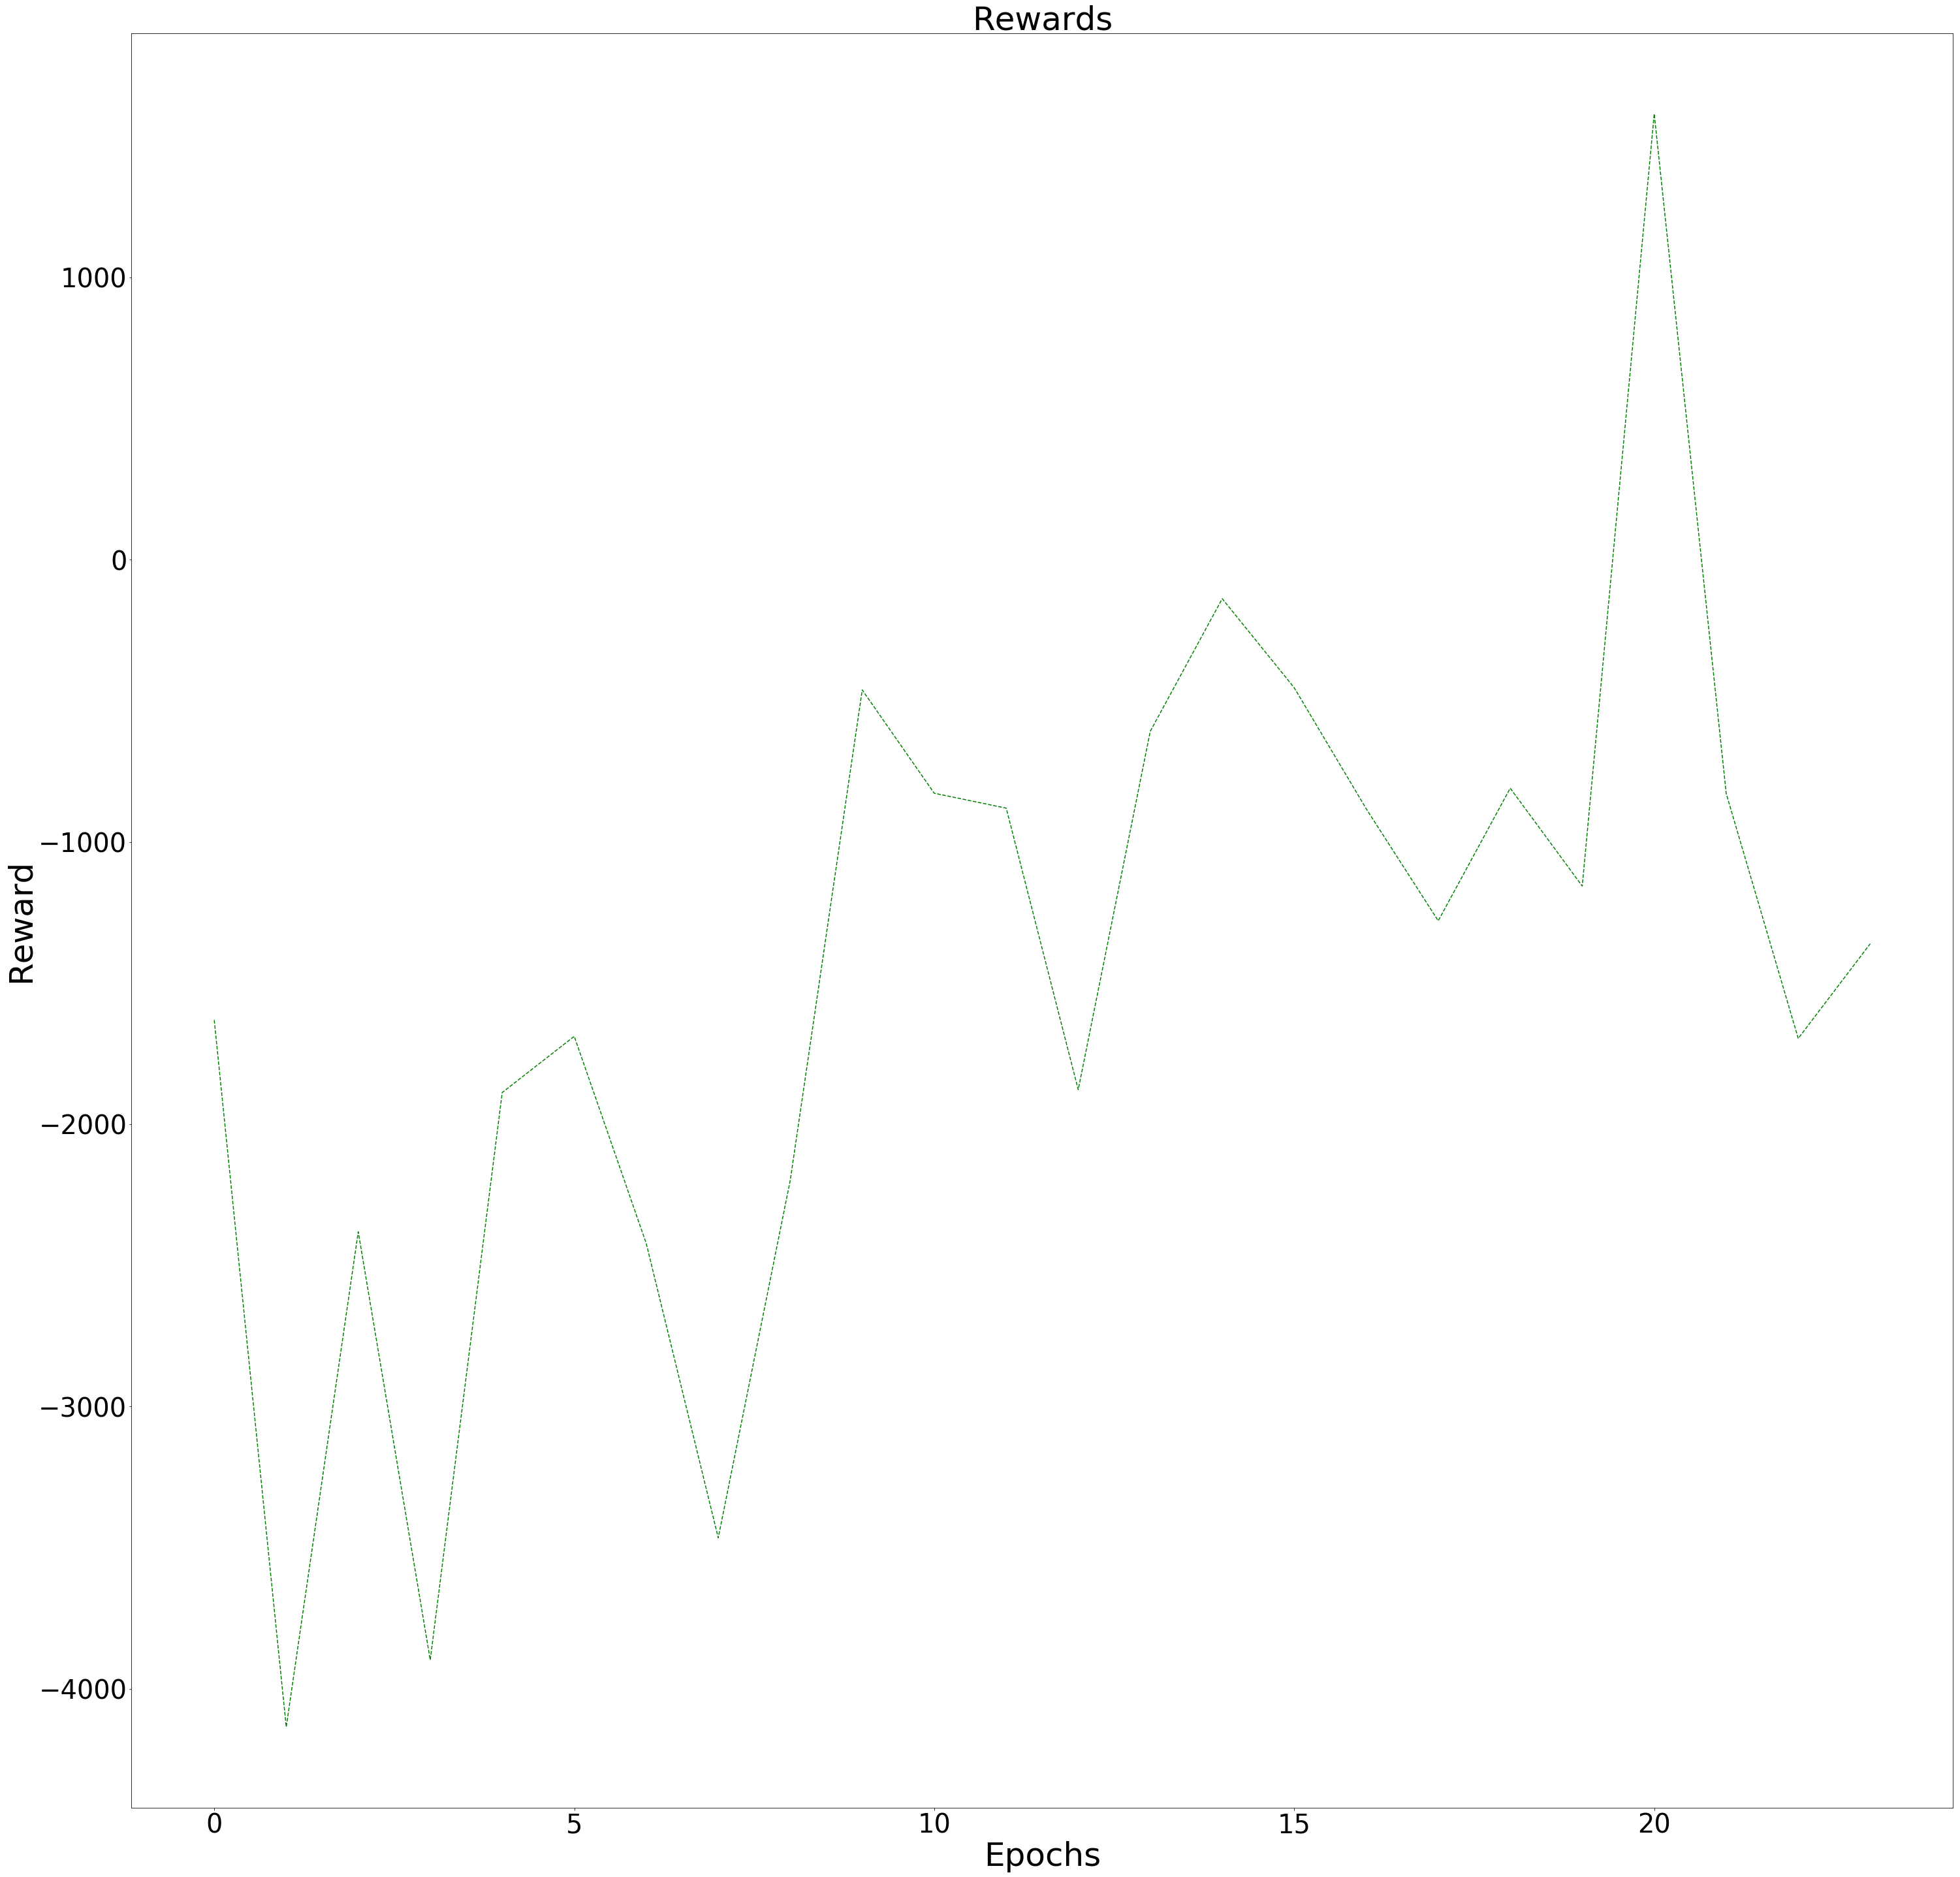

In [9]:
graph = plt.figure()
graph.set_figheight(50)
graph.set_figwidth(50)
plt.plot(dlist,rewards ,'--', label='Rewards' , markersize=20, color = "green" )
plt.xlabel('Epochs' , fontsize=50); 
plt.ylabel('Reward', fontsize=50)
#plt.legend(prop={'size': 60}, loc = 'lower right')
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.autoscale(enable=True, axis='x')
plt.title('Rewards' , fontsize=50)
plt.show()
graph.savefig("Reward.jpg")

[3.21772299 2.96399501 2.72427177 2.69257829 2.89643196 3.78699346
 2.8246906  2.71883872 2.72221621 2.72840636 2.25639499 5.37246032
 4.65174885 4.48156127 3.26952713 3.79941997 4.08829331 4.20197806
 3.47125633 3.2149323  3.20962697 3.1089696  3.47687375 3.33019192
 4.22522276 4.16496194 3.56347662 3.76039707 3.63322499 4.10249267
 4.09497453 3.73912473 3.00824451]


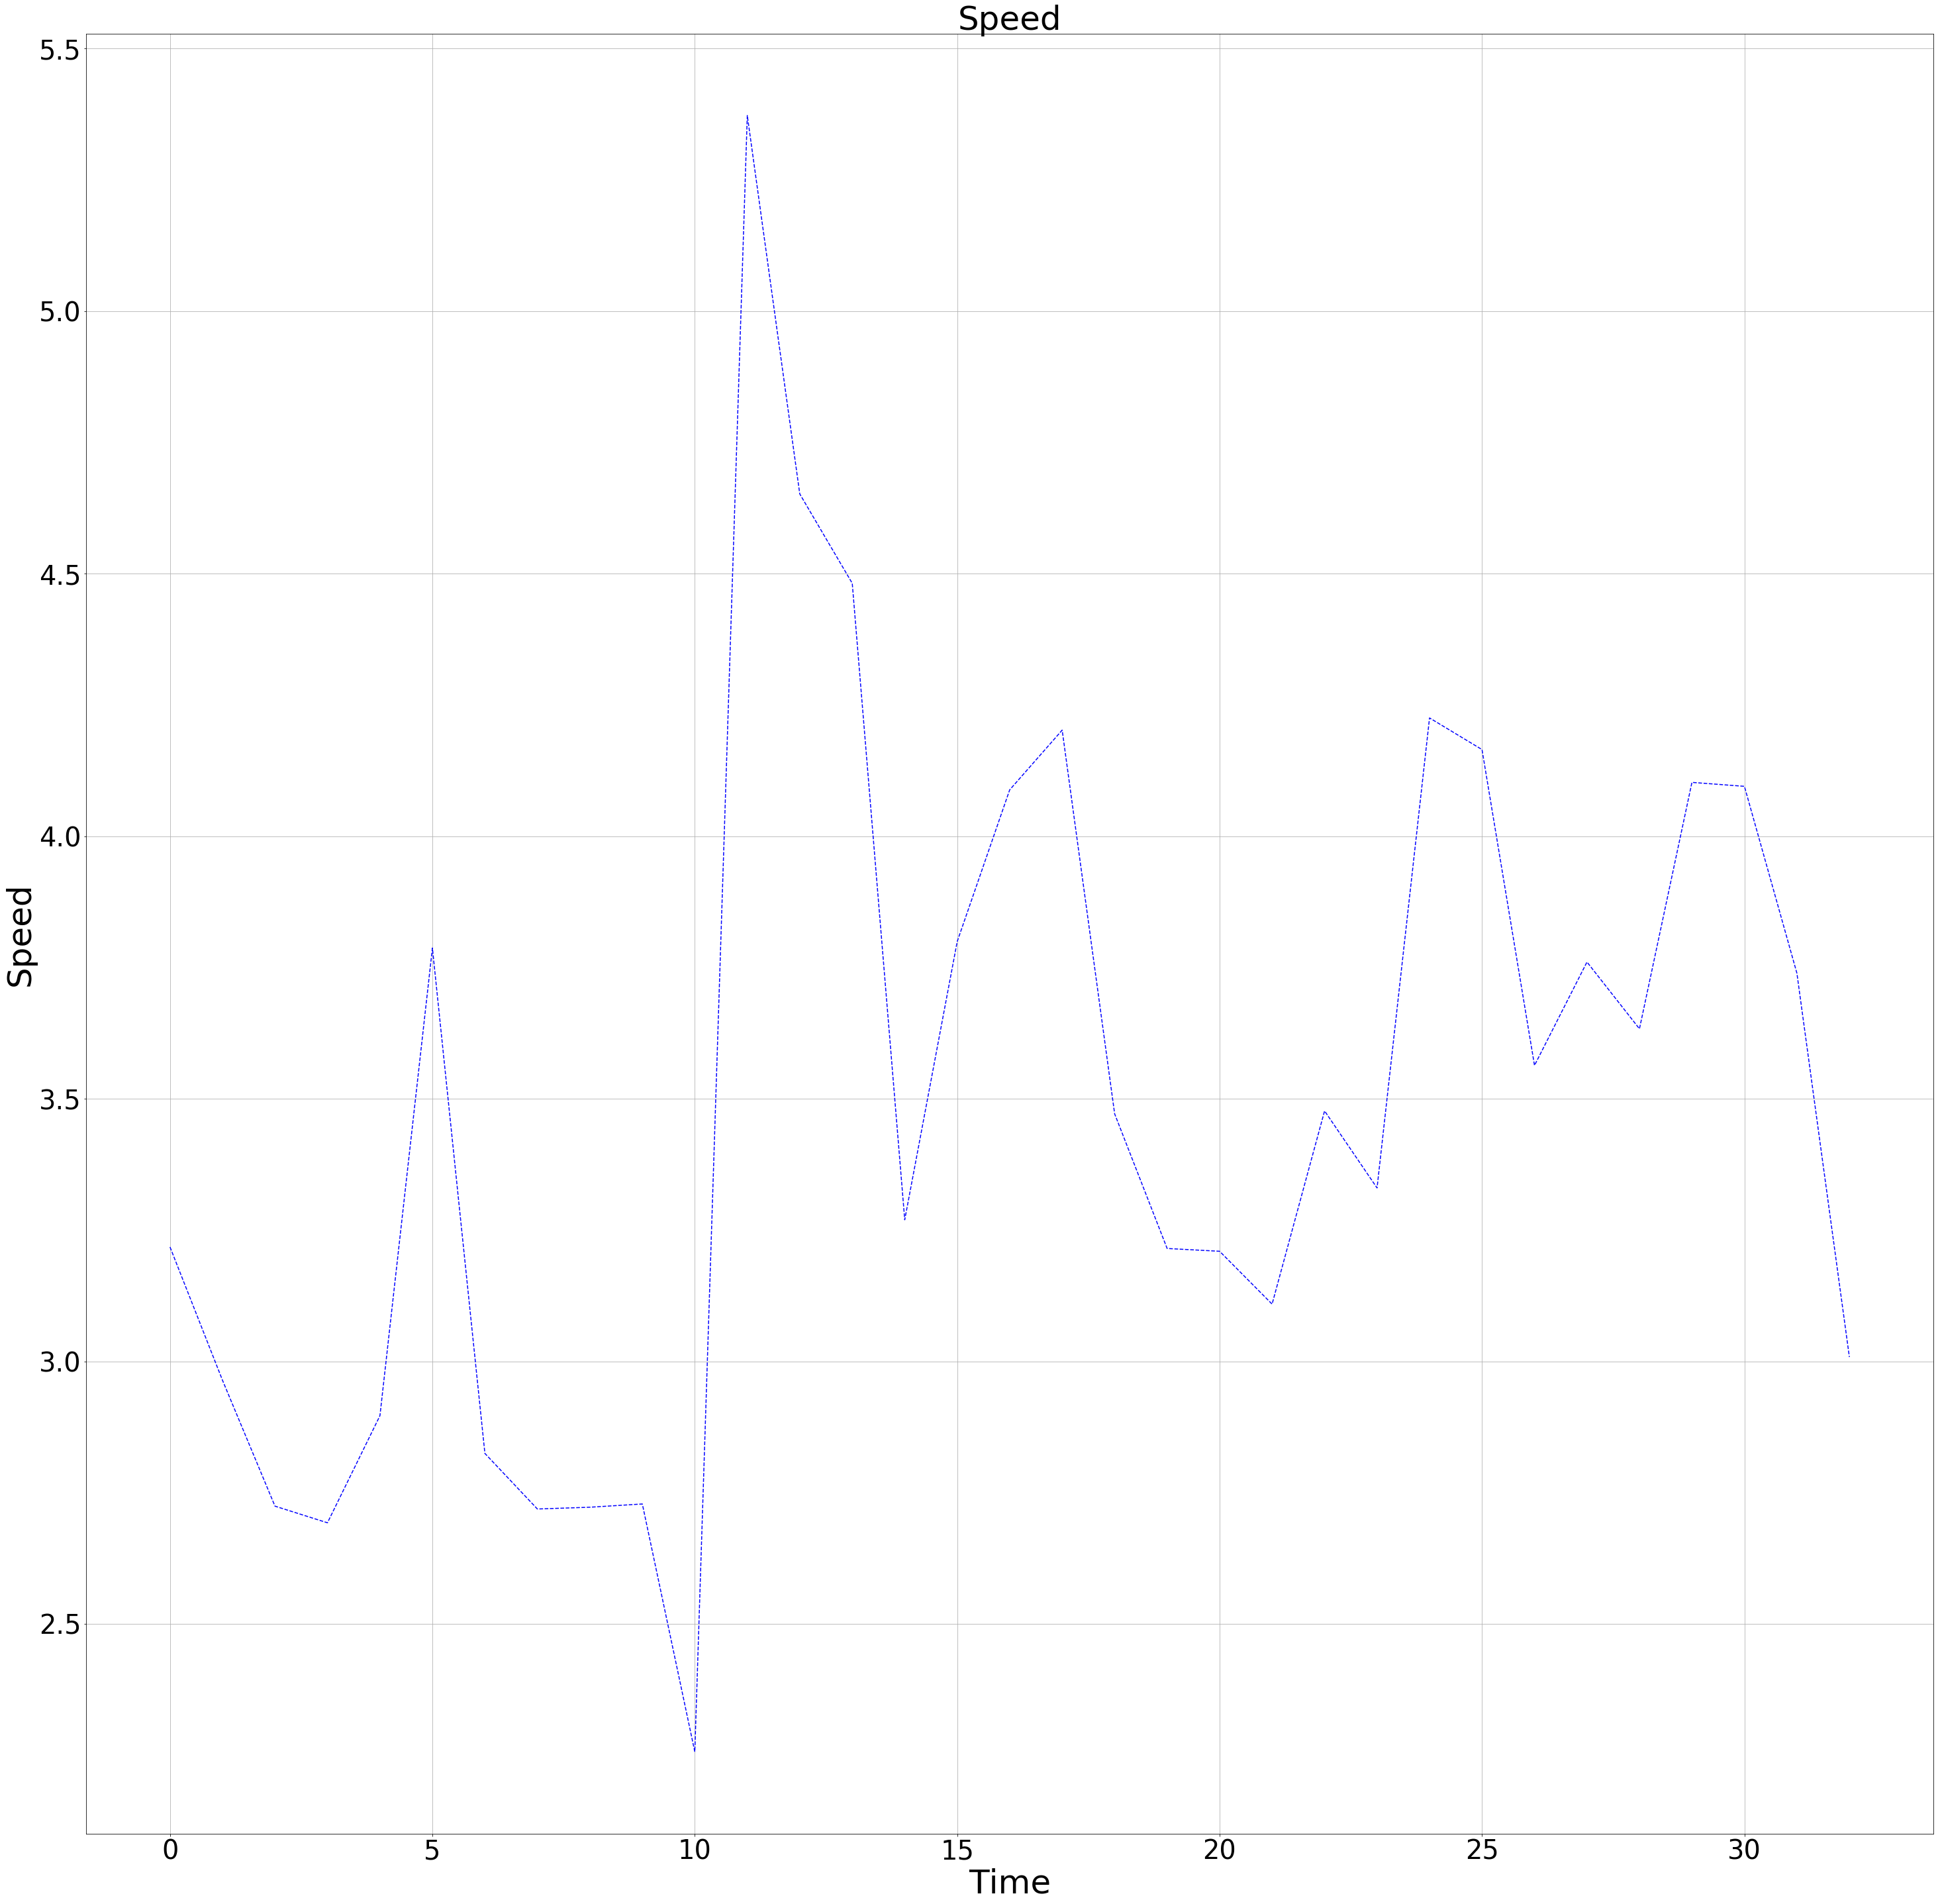

In [10]:
#plot for speed
print(speed_avg)
dlist2 = np.arange(0,speed_avg.size)
graph = plt.figure()
graph.set_figheight(50)
graph.set_figwidth(50)
plt.plot(dlist2,speed_avg ,'--', label='Speed' , markersize=20, color = "blue" )
plt.xlabel('Time' , fontsize=50); 
plt.ylabel('Speed', fontsize=50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.autoscale(enable=True, axis='x')
plt.title('Speed' , fontsize=50)
plt.grid()
plt.show()
graph.savefig("Speed.jpg")

In [ ]:
'''
#Steering version
print(dis_avg)
dlist2 = np.arange(0,dis_avg.size)
graph = plt.figure()
graph.set_figheight(50)
graph.set_figwidth(50)
plt.plot(dlist2,dis_avg ,'--', label='Rewards' , markersize=20, color = "green" )
plt.xlabel('Epochs' , fontsize=50); 
plt.ylabel('distance', fontsize=50)
#plt.legend(prop={'size': 60}, loc = 'lower right')
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.autoscale(enable=True, axis='x')
plt.title('distance' , fontsize=50)
plt.show()
graph.savefig("dis_steering.jpg")
'''